In [1]:
using Revise

using RigidBodyDynamics
using RigidBodyDynamics: Bounds

using DrakeVisualizer
using Plots
using RigidBodyTreeInspector

using BilevelTrajOpt
gr(size=(500,500), html_output_format=:png);

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/8c8a043c2f00369f3e7ae550277d2a54e59a34ad-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/8c8a043c2f00369f3e7ae550277d2a54e59a34ad-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= Bounds(-100, 100)
velocity_bounds(floatingjoint) .= Bounds(-100, 100)
μ = 0.5
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005;

In [16]:
q0 = [1., 0., 0., 0., 0., 0., 1.]
v0 = [0., 0., 0., 0., 0. , 0.]
N = 5

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

ctrl! = (u,t,x) -> u[:] = 0.

println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate(x0,env,Δt,N,ctrl!,implicit_contact=true);

Implicit Contacts


elapsed time: 0.27721076 seconds
elapsed time: 0.20661904 seconds
elapsed time: 0.205113099 seconds
elapsed time: 0.236046001 seconds
elapsed time: 0.262409773 seconds
elapsed time: 0.836104757 seconds
elapsed time: 0.218444508 seconds
elapsed time: 0.203000378 seconds
elapsed time: 0.222899414 seconds
elapsed time: 0.20547825 seconds
elapsed time: 0.230722063 seconds
elapsed time: 0.771197143 seconds
elapsed time: 0.263526257 seconds
elapsed time: 0.283999168 seconds
elapsed time: 0.231794271 seconds
elapsed time: 0.257719063 seconds
elapsed time: 0.272006371 seconds
elapsed time: 0.260261717 seconds
elapsed time: 0.281484312 seconds
elapsed time: 0.34101167 seconds
elapsed time: 0.310892596 seconds
elapsed time: 0.305245967 seconds
elapsed time: 0.244238502 seconds
Solved_To_Acceptable_Level
elapsed time: 0.288256518 seconds
elapsed time: 0.20914372 seconds
elapsed time: 0.217498389 seconds
elapsed time: 0.224271923 seconds
elapsed time: 0.286370605 seconds
elapsed time: 0.856669188 

In [18]:
println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate(x0,env,Δt,N,ctrl!,implicit_contact=false);

Explicit Contacts
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded


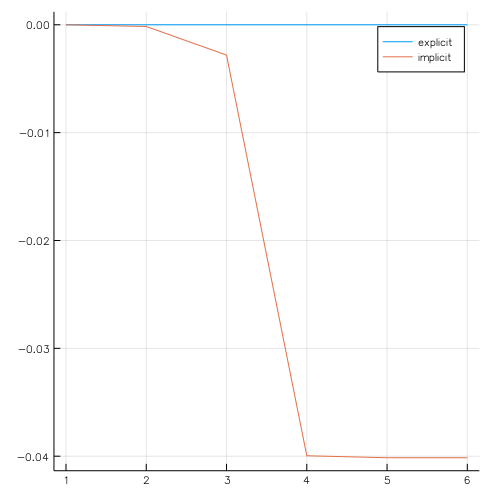

In [19]:
ts = cumsum([Δt for i in 1:N]);
j = 11
plot(traj_exp[j,:],label="explicit")
plot!(traj_imp[j,:],label="implicit")

In [20]:
traj_imp

19×6 Array{Float64,2}:
 1.0   1.0           1.0           1.0           1.0           1.0        
 0.0   9.32476e-10   9.32489e-10   9.32501e-10   9.32517e-10   9.32529e-10
 0.0   1.13661e-9    1.13662e-9    1.13663e-9    1.13665e-9    1.13667e-9 
 0.0  -3.46711e-12  -3.46713e-12  -3.46717e-12  -3.46809e-12  -3.46813e-12
 0.0  -8.07392e-7   -1.48681e-5   -0.000214657  -0.000415371  -0.000616085
 0.0  -6.92688e-6   -7.28527e-6    3.19483e-6    1.16671e-5    2.01393e-5 
 1.0   1.0005        1.00189       1.0045        1.00707       1.00943    
 0.0   4.67447e-12   4.67448e-12   4.67448e-12   4.6745e-12    4.6745e-12 
 0.0   5.70334e-12   5.70334e-12   5.70335e-12   5.70338e-12   5.70338e-12
 0.0  -1.71862e-14  -1.71861e-14  -1.71861e-14  -1.71914e-14  -1.71914e-14
 0.0  -0.000161478  -0.00281214   -0.0399577    -0.0401428    -0.0401428  
 0.0  -0.00138537   -7.16781e-5    0.00209602    0.00169445    0.00169445 
 0.0   0.100219      0.278778      0.521512      0.514321      0.470337   
 0

In [ ]:
traj_exp